<a href="https://colab.research.google.com/github/MrBenjaminHolmes/Gravitational-Waves/blob/main/GWpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational Wave Open Data Scripts

##Initialization

In [1]:
# Step 1: Install all required packages with pinned versions
!pip install -q lalsuite==7.25 scipy==1.12.0 gwpy==3.0.12 bilby==2.4.0 matplotlib==3.10.0 dynesty==2.1.5 corner==2.2.3 numpy==1.26.4 PyCBC==2.4.1

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


import matplotlib.pyplot as plt
import numpy
import os
import urllib

import logging
logging.getLogger('bilby').setLevel(logging.ERROR)
import corner

#Bilby
import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

# GW
import gwpy
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps

# PyCBC
import pycbc
import pycbc.noise
import pycbc.psd
from pycbc.catalog import Merger
from pycbc.detector import Detector
from pycbc.events.ranking import newsnr
from pycbc.filter import (
    highpass,
    matched_filter,
    resample_to_delta_t,
    sigma
)
from pycbc.vetoes import power_chisq
from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import (
    fd_approximants,
    get_td_waveform,
    get_fd_waveform,
    td_approximants
)

##Noise Comparison 1.1

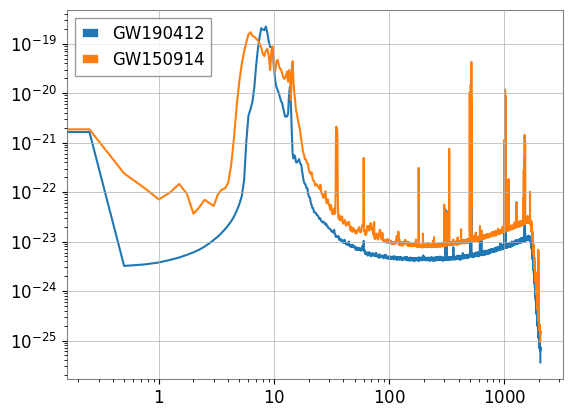

In [3]:
#--GW190412 Data-#
gw19 = event_gps('GW190412')
gw19Data = TimeSeries.fetch_open_data('L1', int(gw19)-512, int(gw19)+512, cache=True)
gw19ASD = gw19Data.asd(fftlength=4, method="median")

#--GW150914 Data-#
gw15 = event_gps('GW150914')
gw15Data = TimeSeries.fetch_open_data('L1', int(gw15)-512, int(gw15)+512, cache=True)
gw15ASD = gw15Data.asd(fftlength=4, method="median")

plt.loglog(gw19ASD, label = 'GW190412')
plt.loglog(gw15ASD,label = 'GW150914')
plt.legend()

plt.show()

##Spectogram 1.2

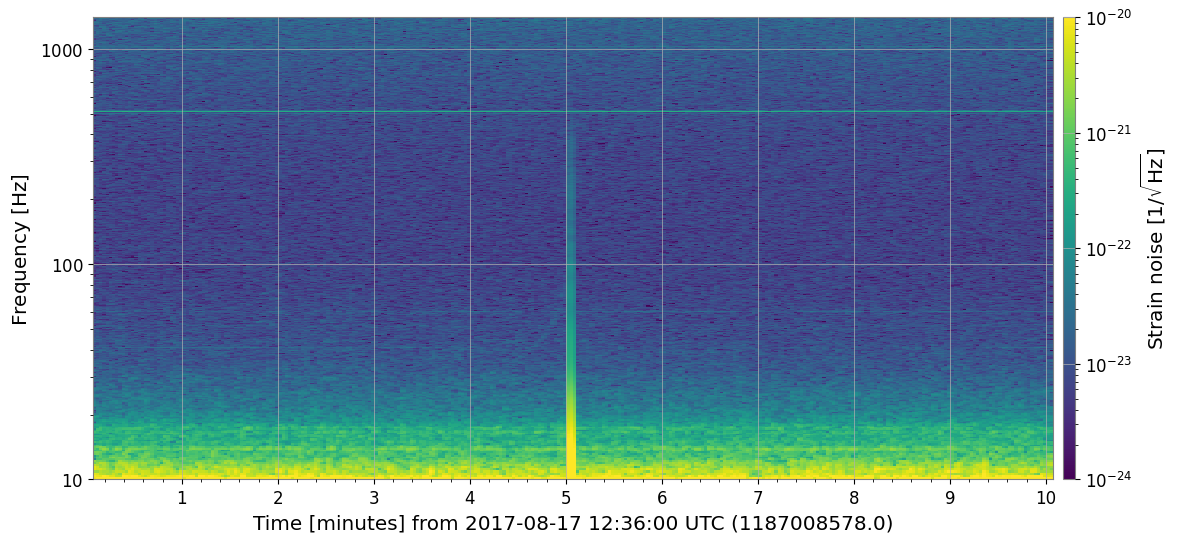

In [4]:
gps = event_gps("GW170817")
ldata = TimeSeries.fetch_open_data("L1", gps - 300, gps + 300, cache=True)
specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (0.5)
plot = specgram.plot();

ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)

##Q-Transform 1.3

Fetched 1 URLs from gwosc.org for [1186741856 .. 1186741863))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1186741856 .. 1186741863))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1186741856 .. 1186741863))
Reading data... [Done]


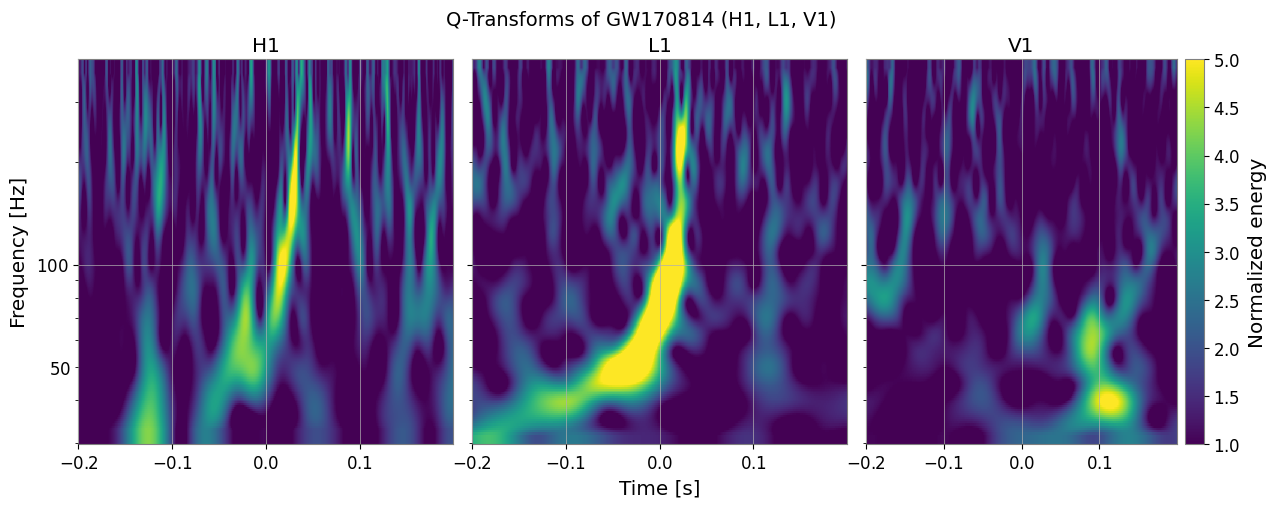

In [5]:
gps = event_gps("GW170814")
segment = (int(gps) - 5, int(gps) + 2)
hData = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
lData = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)
vData = TimeSeries.fetch_open_data('V1', *segment, verbose=True, cache=True)

hq = hData.q_transform(frange=(30, 400), qrange=(4, 20), outseg=(gps-0.2, gps+0.2))
lq = lData.q_transform(frange=(30, 400), qrange=(4, 20), outseg=(gps-0.2, gps+0.2))
vq = vData.q_transform(frange=(30, 400), qrange=(4, 20), outseg=(gps-0.2, gps+0.2))

hq_plot = hq.abs()**0.5
lq_plot = lq.abs()**0.5
vq_plot = vq.abs()**0.5

#-----------Graphing Data-----------#
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)

xt_h = hq_plot.times.value - gps
xt_l = lq_plot.times.value - gps
xt_v = vq_plot.times.value - gps

im0 = ax[0].pcolormesh(xt_h, hq_plot.frequencies.value, hq_plot.value.T, vmin=1, vmax=5)
im1 = ax[1].pcolormesh(xt_l, lq_plot.frequencies.value, lq_plot.value.T, vmin=1, vmax=5)
im2 = ax[2].pcolormesh(xt_v, vq_plot.frequencies.value, vq_plot.value.T, vmin=1, vmax=5)

# Axis formatting
ax[0].set_title('H1')
ax[1].set_title('L1')
ax[2].set_title('V1')

ax[1].set_xlabel("Time [s]")

for a in ax:
    a.set_yscale('log')

ax[0].set_ylabel('Frequency [Hz]')


cbar = fig.colorbar(im2, ax=ax[2], pad=0.02)
cbar.set_label('Normalized energy')

fig.subplots_adjust(wspace=0.05)
plt.suptitle("Q-Transforms of GW170814 (H1, L1, V1)", fontsize=14)
plt.show()
#---------------------------------------#

##Strain VS Mass 1.4

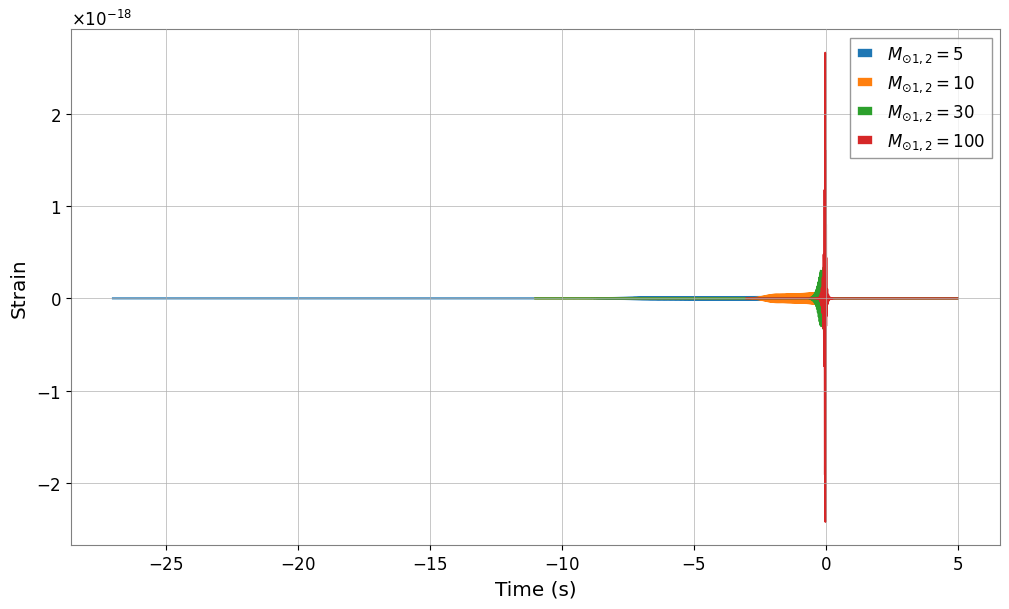

In [6]:
plt.figure(figsize=(10, 6))
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    plt.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

##Waveform Generation 1.5

|  Data  | Value |
| ------------- | ------------- |
| Mass 1  (☉)|  1.46 |
| Mass 2 (☉)|  1.27 |
| Distance (Mpc) |  40 |


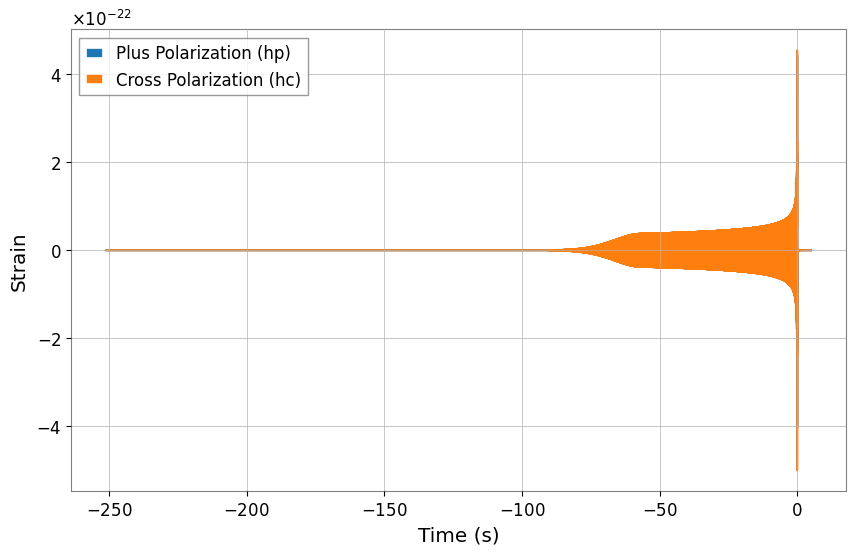

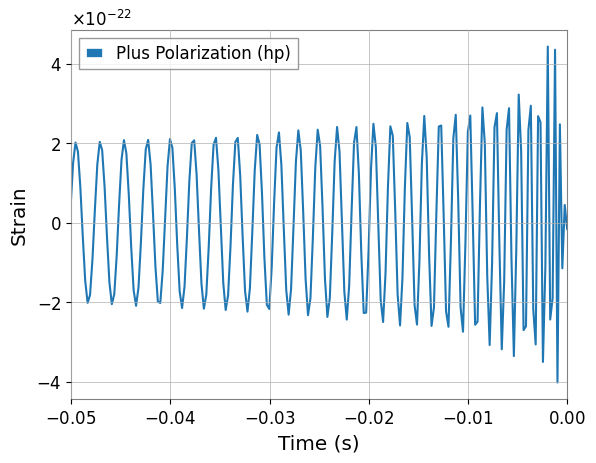

In [7]:
plt.figure(figsize=(10, 6))
hp,hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=1.46,
                         mass2=1.27,
                         delta_t=1.0/4096,
                         f_lower=30,
                        distance = 40
                        )
plt.plot(hp.sample_times, hp, label='Plus Polarization (hp)')
plt.plot(hc.sample_times, hc, label='Cross Polarization (hc)')
plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

plt.plot(hp.sample_times, hp, label='Plus Polarization (hp)')

plt.legend()
plt.grid(True)
plt.xlim(-0.05,0)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

## Manual Matched Filtering 2.1

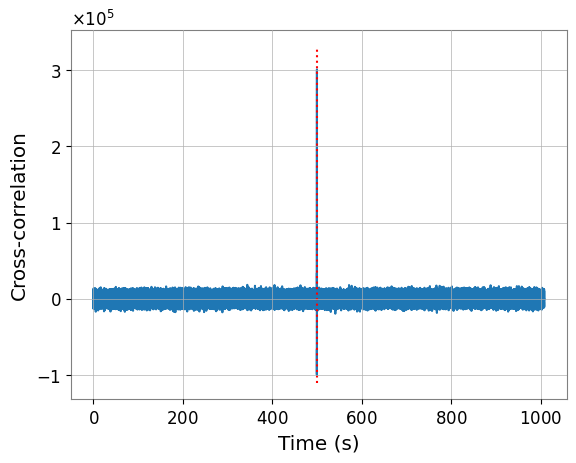

In [8]:
# Define Sample Properties
sample_rate = 1024
data_length = 1024

# Generate Signal
hp1, _ = get_td_waveform(approximant="IMRPhenomD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)
hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5

#Injection Time
fixed_time = 500
waveform_start = int(fixed_time * sample_rate)

# Create sample PSD
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate Fake Noise from PSD
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Inject FAKE event into code
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

# PSD's for Whittening
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# Avoding NaNs and 0 Division
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# Whitten the Noise and the Waveform
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

# Create NumPy Arrays for Data

hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
cross_correlation = numpy.zeros([len(datan)-len(hp1)])

# Slide Template Across Sample
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum() # Calulcate Product


# Plotting
plt.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

###Checking Normality: Mean and Standard Deviation of Whitened Data
Histogram the whitened time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation?

Standard Deviation: 22.474780529700006


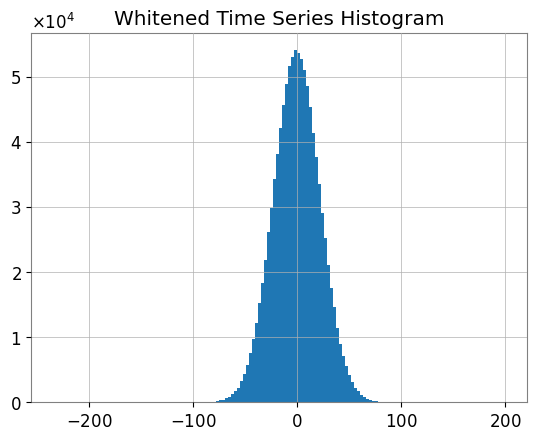

In [9]:
plt.title("Whitened Time Series Histogram")
plt.hist(data_whitened,bins=150)
print("Standard Deviation:", numpy.std(data_whitened))

Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation?

Standard Deviation:  3988.1603451477667


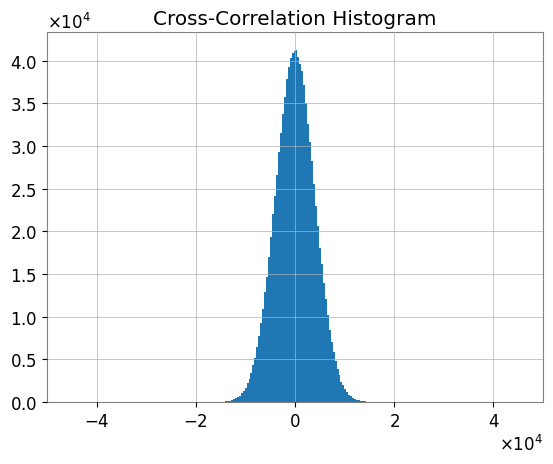

In [10]:
plt.xlim(-50000,50000)
plt.title("Cross-Correlation Histogram")
plt.hist(cross_correlation,bins=int(numpy.sqrt(len(cross_correlation))))
print("Standard Deviation: ", numpy.std(cross_correlation))

Find the location of the peak. (Note that here, it can be positive or negative), and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series).

In [11]:
#Order Cross-Correlation in Size
peak_index = numpy.argmax(abs(cross_correlation))
peak_time = times[peak_index]
peak_value = cross_correlation[peak_index]

print("Signal Location: ",peak_time,"S")

signal_value = abs(peak_value)/numpy.std(cross_correlation)
print("Signal Value:", signal_value)

Signal Location:  500.0 S
Signal Value: 75.39742094207936


## Subtracting Signals 2.21


###Get Raw Data

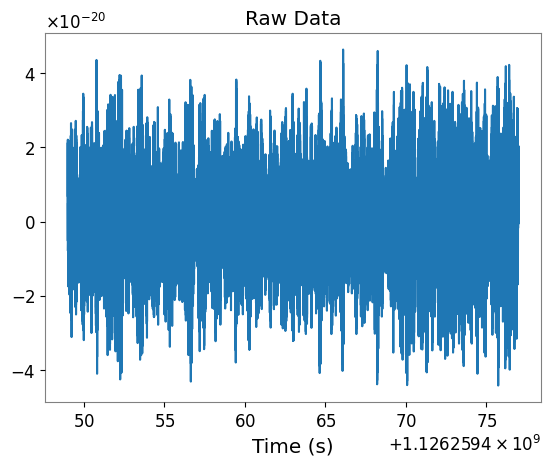

In [12]:
#Get Merger Raw Signal
merger = Merger("GW150914")
strain = merger.strain("H1")

#Remove Low Frequencies with a Highpass
strain = highpass(strain,15)
#Resample data
strain = resample_to_delta_t(strain,1/2048)
#Crop Start and End Peaks
strain = strain.crop(2, 2)

plt.plot(strain.sample_times, strain)
plt.title("Raw Data")
plt.grid(False)
plt.xlabel('Time (s)')
plt.show()

###Matched Filtering

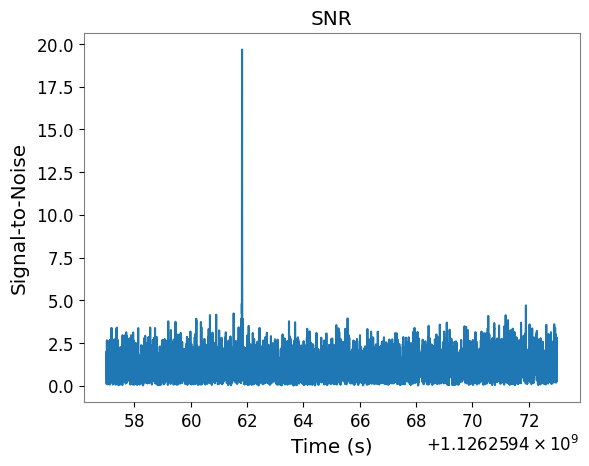

We found a signal at 1126259461.8232422s with SNR 19.682364225753332


In [13]:
#Create PSD
psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15)

#Create Event Template
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=36,
                     mass2=36,
                     delta_t=strain.delta_t,
                     f_lower=20)

# Resize the Waveform Vector to match our data
hp.resize(len(strain))

snr = matched_filter(hp, strain,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)
plt.plot(snr.sample_times,abs(snr))
plt.title("SNR")
plt.grid(False)
plt.xlabel("Time (s)")
plt.ylabel("Signal-to-Noise")
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

###Align Template

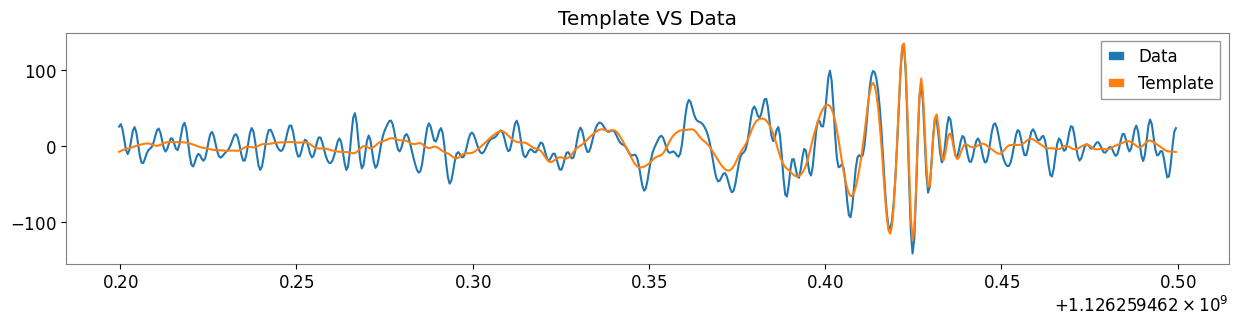

In [14]:
dt = time-strain.start_time
aligned = hp.cyclic_time_shift(dt)

#Scale so SNR=1 in the Data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = strain.start_time


white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

#Highpass and Lowpass on Both
white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

#Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)


plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data, label="Data")
plt.plot(white_template.sample_times, white_template, label="Template")
plt.grid(False)
plt.title("Template VS Data")
plt.legend()
plt.show()

### Subtraction

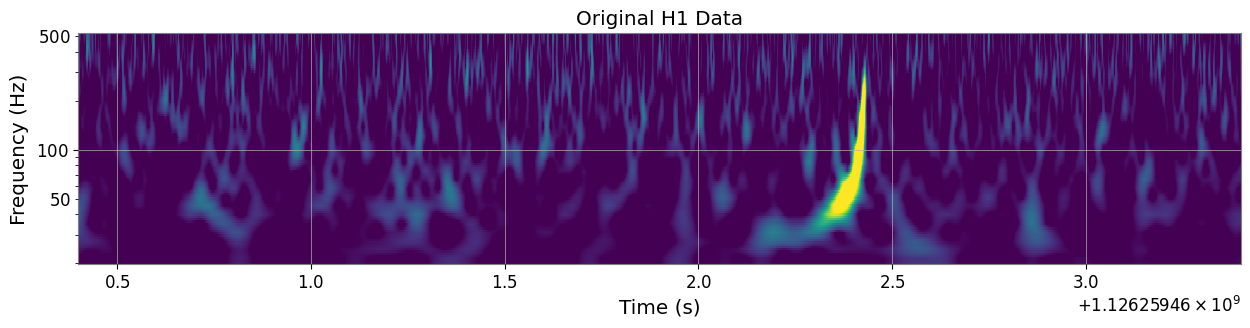

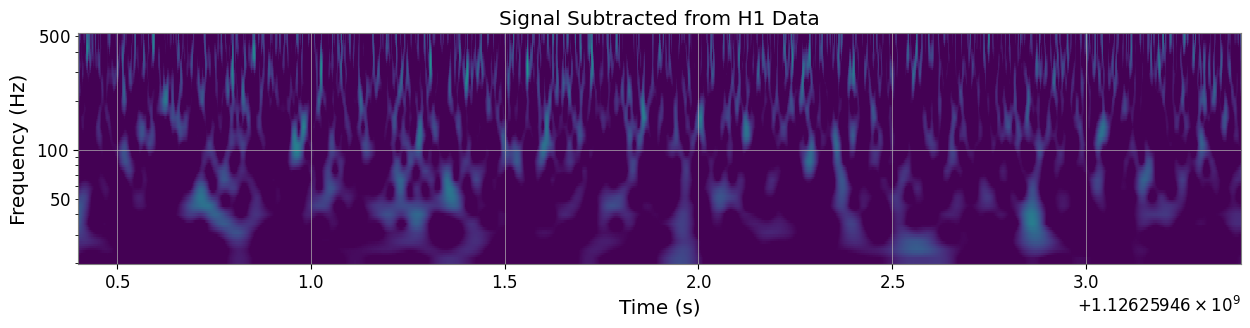

In [15]:
subtracted = strain-aligned

for data, title in [(strain, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:
                      time,frequency,power = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
                      plt.figure(figsize=[15, 3])
                      plt.pcolormesh(time,frequency,power**0.5, vmin=1, vmax=6, shading='auto')
                      plt.title(title)
                      plt.yscale('log')
                      plt.xlabel('Time (s)')
                      plt.ylabel('Frequency (Hz)')
                      plt.xlim(merger.time - 2, merger.time + 1)
                      plt.show()

## SNR Signal Matching 2.22

Calculate the SNR time series in the following data sets. What is the SNR of each signal? Which template matched best to which data?

Information that may be useful:

Signals are all placed between 100 and 120 seconds into the frame file.
You may assume mass1 = mass2 (equal mass) and that each component mass is one of 15, 30, or 45.
Each file starts at gps time 0, and ends at gps time 128
The channel name in each file is "H1:TEST-STRAIN"

###Gather Raw Data

Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/2.22/PyCBC_T2_0.gwf
Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/2.22/PyCBC_T2_1.gwf
Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/2.22/PyCBC_T2_2.gwf


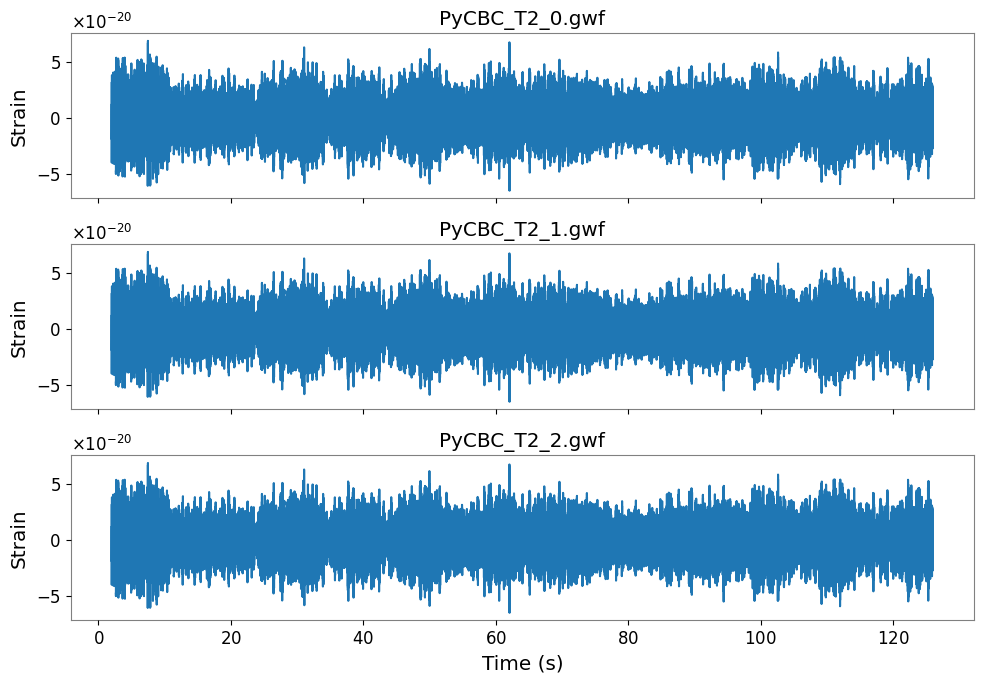

In [16]:

def get_file(fname):
    url = f"https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/2.22/{fname}"
    urllib.request.urlretrieve(url, fname)
    print(f'Getting: {url}')

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf']
channel_name = "H1:TEST-STRAIN"
start = 0
end = start + 128
conditionedData = []
fig, axs = plt.subplots(len(files), 1, figsize=(10, 7), sharex=True)

for i, file_name in enumerate(files):
    get_file(file_name)
    ts = read_frame(file_name, channel_name, start, end)
    ts  = highpass(ts ,15)
    ts  = resample_to_delta_t(ts ,1/2048)
    ts = ts.crop(2,2)
    conditionedData.append([file_name,ts])
    axs[i].plot(ts.sample_times, ts.data)
    axs[i].set_title(f"{file_name}")
    axs[i].grid(False)
    axs[i].set_ylabel("Strain")

axs[-1].set_xlabel("Time (s)")
plt.tight_layout()

plt.show()

###Filtering

------------- PyCBC_T2_0.gwf -------------
Signal at 102.052734375s with SNR 5.590479771081665 using mass 15
Signal at 104.15673828125s with SNR 8.954908277088691 using mass 30
Signal at 104.60791015625s with SNR 12.867380075968004 using mass 45


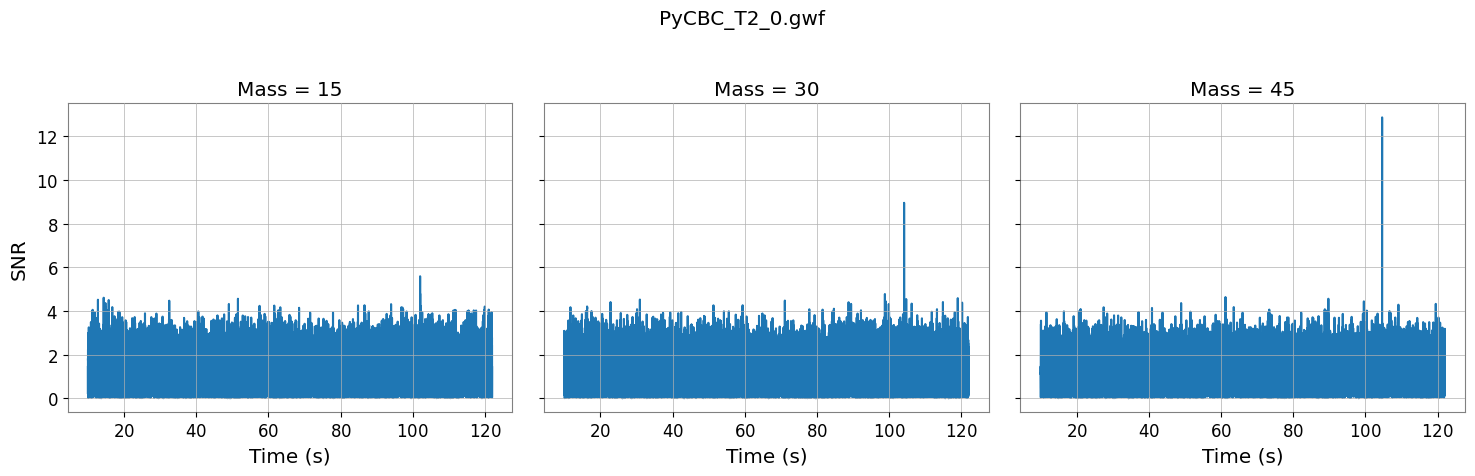

------------- PyCBC_T2_1.gwf -------------
Signal at 115.0439453125s with SNR 9.005419121776077 using mass 15
Signal at 117.15234375s with SNR 21.912539641464434 using mass 30
Signal at 117.60205078125s with SNR 15.990413721148398 using mass 45


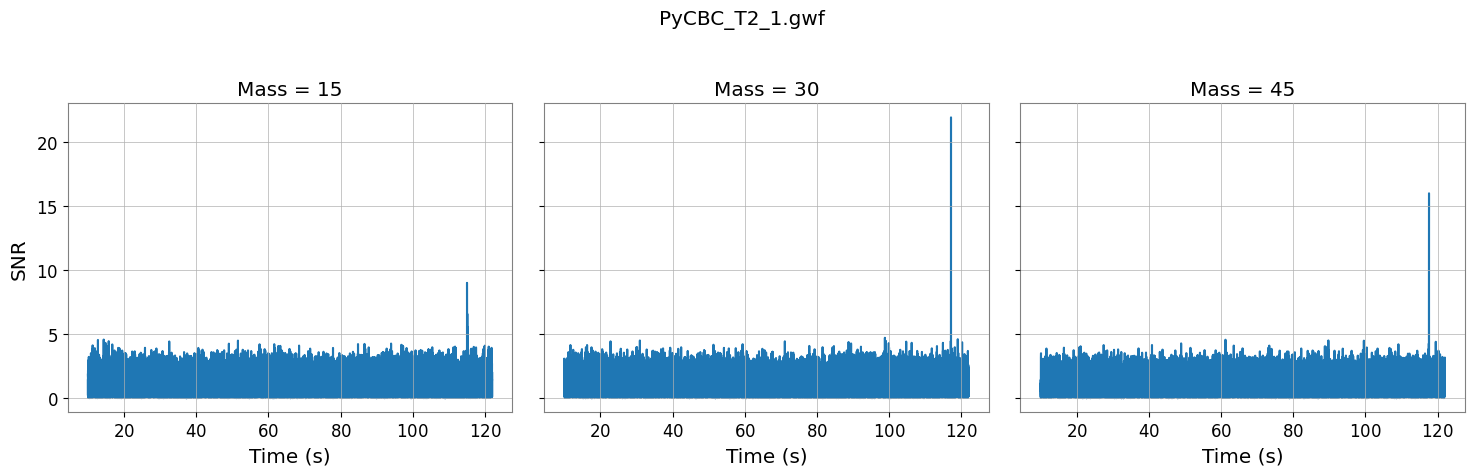

------------- PyCBC_T2_2.gwf -------------
Signal at 98.03515625s with SNR 9.132225532462627 using mass 15
Signal at 99.9853515625s with SNR 5.187664678465255 using mass 30
Signal at 61.20361328125s with SNR 4.579880219845696 using mass 45


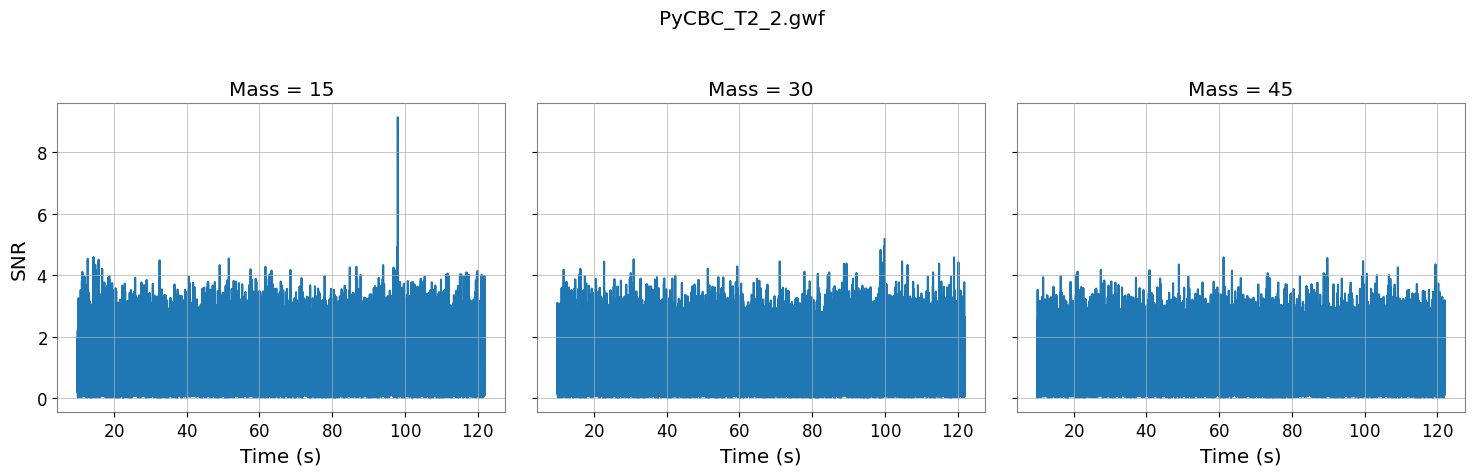

In [17]:
masses = [15, 30, 45]

for i, strain_data in enumerate(conditionedData):
    fig, axs = plt.subplots(1, len(masses), figsize=(15, 5), sharey=True)
    fig.suptitle(strain_data[0])

    print(f"------------- {strain_data[0]} -------------")

    for j, mass in enumerate(masses):
        # Create PSD
        psd = strain_data[1].psd(4)
        psd = interpolate(psd,  strain_data[1].delta_f)
        psd = inverse_spectrum_truncation(psd, int(4 *  strain_data[1].sample_rate),
                                          low_frequency_cutoff=15)

        # Create Event Template
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=mass,
                                 mass2=mass,
                                 delta_t= strain_data[1].delta_t,
                                 f_lower=20)

        # Resize waveform vector to match data length
        hp.resize(len( strain_data[1]))

        # Matched filter
        snr = matched_filter(hp,strain_data[1],
                             psd=psd, low_frequency_cutoff=20)
        snr = snr.crop(4 + 4, 4)

        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]

        axs[j].plot(snr.sample_times, abs(snr))
        axs[j].set_title(f'Mass = {mass}')
        axs[j].set_xlabel('Time (s)')
        if j == 0:
            axs[j].set_ylabel('SNR')

        print(f"Signal at {time}s with SNR {abs(snrp)} using mass {mass}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


##Signal Consistency and Significance 2.3

Use the methods to see if you can calculate the SNR time series and re-weighted SNR timeseries in the following data set. This data set contains one signal and two glitches. At what times do you find peaks in the SNR timeseries? Which peaks are still present in the re-weighted SNR timeseries?

Information that may be useful:

* The signal and glitches are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass2 (equal mass) and that the component mass of the signal is 32.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/2.3/PyCBC_T3_0.gwf


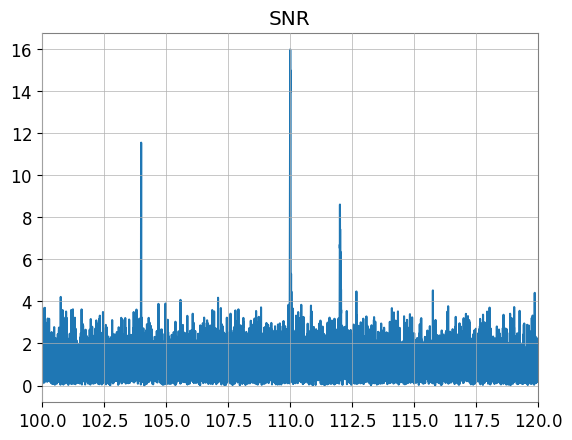

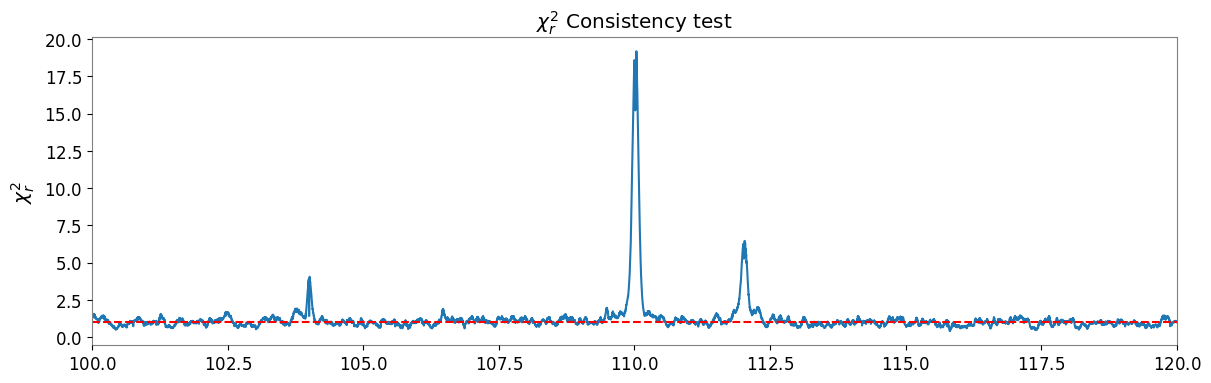

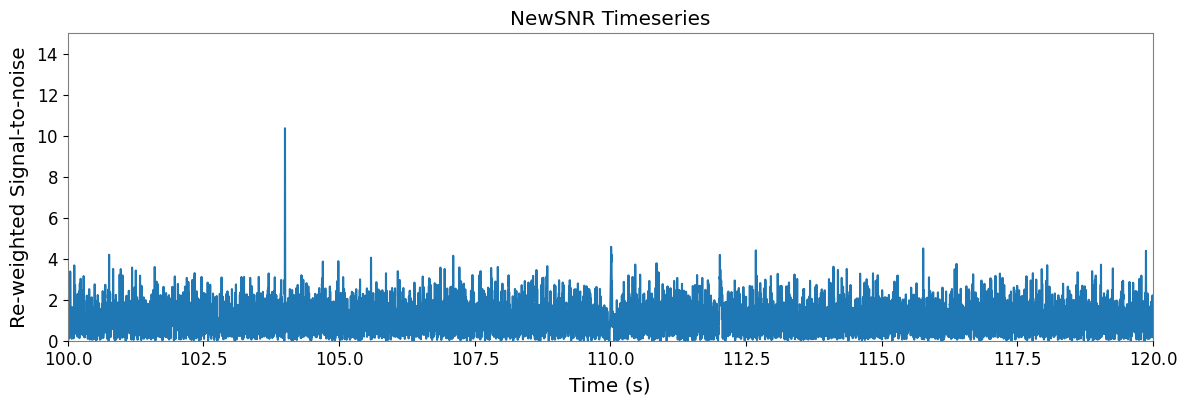

In [18]:
def get_file(fname):
    url = f"https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/2.3/{fname}"
    urllib.request.urlretrieve(url, fname)
    print(f'Getting: {url}')

file_name = 'PyCBC_T3_0.gwf'
channel_name = "H1:TEST-STRAIN"
start = 0
end = start + 128

get_file(file_name)

# Load and preprocess strain
ts = read_frame(file_name, channel_name, start, end)
ts = ts.highpass_fir(15, 512)
ts = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

# Compute PSD
psd = ts.psd(2)
psd = interpolate(psd, ts.delta_f)
psd = inverse_spectrum_truncation(psd, int(2 * ts.sample_rate), low_frequency_cutoff=15.0)

# Generate waveform
hp, _ = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=32, mass2=32,
                         f_lower=20.0, delta_f=ts.delta_f)
hp.resize(len(ts.to_frequencyseries()))

# Matched filter
snr = matched_filter(hp, ts, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(5, 4)

# Plot SNR
plt.plot(snr.sample_times, abs(snr.data))
plt.title("SNR")
plt.xlim(100, 120)
plt.show()

# Chi-squared test
nbins = 26
chisq = power_chisq(hp, ts, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(5, 4)
dof = nbins * 2 - 2
chisq /= dof

plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq.data)
plt.axhline(y=1, color='red', linestyle='--', label='y = 1')
plt.grid()
plt.title("$\chi^2_r$ Consistency test")
plt.xlim(100, 120)
plt.ylabel('$\chi^2_r$')
plt.show()


nsnr_x = newsnr(abs(snr), chisq)

# Plot the new SNR timeseries
plt.figure(figsize=[14, 4])
plt.plot(snr.sample_times, nsnr_x, label='H1')
plt.title('NewSNR Timeseries')
plt.grid()
plt.xlim(100,120)
plt.ylim(0, 15)
plt.xlabel('Time (s)')
plt.ylabel('Re-weighted Signal-to-noise')
plt.show()

## Parameter Estimation 3.1

Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/3.1/toy_model.csv


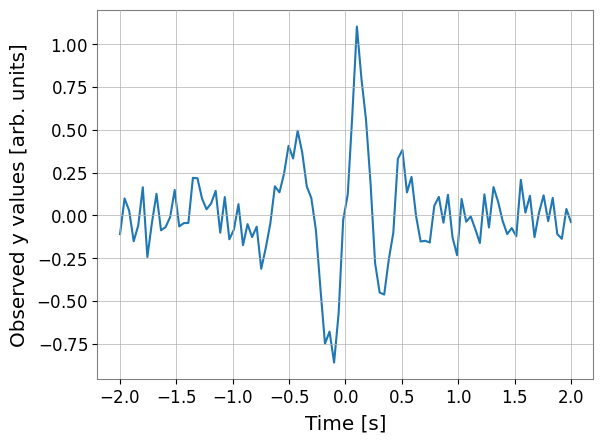

12:29 bilby INFO    : Running for label 'model_Ms', output will be saved to 'toy_model'
12:29 bilby INFO    : Analysis priors:
12:29 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:29 bilby INFO    : alpha=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
12:29 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:29 bilby INFO    : Analysis likelihood noise evidence: nan
12:29 bilby INFO    : Single likelihood evaluation took 9.867e-05 s
12:29 bilby INFO    : Using sampler Bilby_MCMC with kwargs {'nsamples': 1000, 'nensemble': 1, 'pt_ensemble': False, 'ntemps': 1, 'Tmax': None, 'Tmax_from_SNR': 20, 'initial_betas': None, 'adapt': True, 'adapt_t0': 100, 'adapt_nu': 10, 'pt_rejection_sample': False, 'burn_in_nact': 10, 'thin_by_nact': 1, 'fixed_discard': 0, 'autocorr_c': 5, 'L1steps': 1, 'L2steps': 3, 'printdt': 60, 'check_point_delta_t': 1800, 'min_

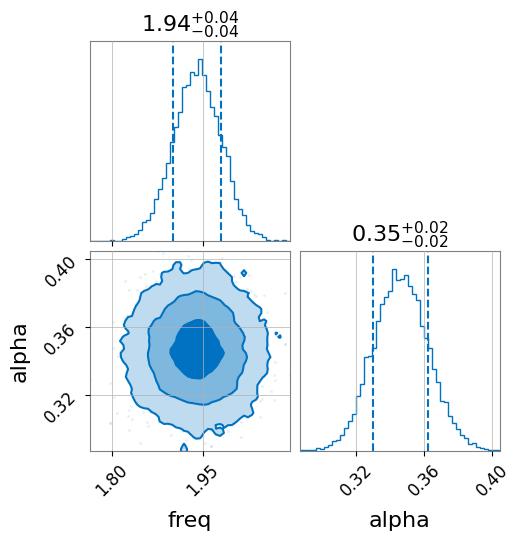

In [19]:
url = "https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/3.1/toy_model.csv"
filename, _ = urllib.request.urlretrieve(url)
print(f'Getting: {url}')

time, yobs = numpy.genfromtxt(filename, delimiter=",").T

fig, ax = plt.subplots()
ax.plot(time, yobs)
ax.set(xlabel="Time [s]", ylabel="Observed y values [arb. units]")
plt.show()

def model_Ms(time, freq, alpha):
    return numpy.exp(-(time/alpha)**2) * numpy.sin(2*numpy.pi*time*freq)

likelihood_Ms = bilby.core.likelihood.GaussianLikelihood(time, yobs, model_Ms, sigma=0.1)

##Set Alpha and Freq Bounds
priors_Ms = dict(
    freq=bilby.core.prior.Uniform(0, 5),
    alpha=bilby.core.prior.Uniform(0, 1)
)

result_Ms = bilby.run_sampler(
    likelihood_Ms,
    priors_Ms,
    label="model_Ms",
    outdir="toy_model",
    clean=True,
    sampler="bilby_mcmc",
    nsamples=1000,
    verbose = False,
    L1steps=1,
)

result_Ms.plot_corner()

###Model vs Data

Create a plot of the raw data (i.e `yobs` against `time`) Then, overlay on it the prediction of your model using the mean for $f$ and $\alpha$ estimated

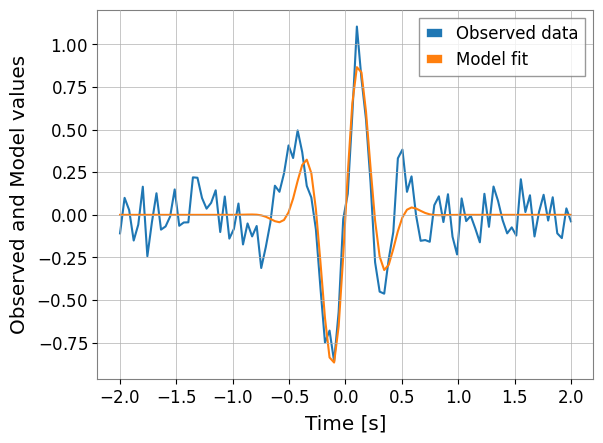

In [20]:
plt.plot(time, yobs)
plt.plot(time, model_Ms(time,
                        result_Ms.posterior.freq.mean(),
                        result_Ms.posterior.alpha.mean()
                       ))
plt.xlabel("Time [s]")
plt.ylabel("Observed and Model values")
plt.legend(["Observed data", "Model fit"])
plt.show()

It is more common to show the maximum likelihood fit and some measure of uncertainty. For the maximum likelihood, this can be obtained from the `posterior` data frame as follow:

- First identify the index of the maximum likelihood point `idx_max = np.argmax(result_Ms.posterior.log_likelihood)`
- Then return the row of the maximum `maxL = result_Ms.posterior.iloc[idx_max]`
- The values can be accessed with `maxL.freq` for example

A straightforward approach is to draw random samples and plot these. You can draw a random sample from the bilby posterior using `result.posterior.sample().iloc[0]` (this will give you a single sample with keys for `freq` and `alpha`). Draw 100 samples from the posterior and overplot them alongside your mean estimate.

Text(0.5, 1.0, 'Maximum Likelihood Fit with Samples')

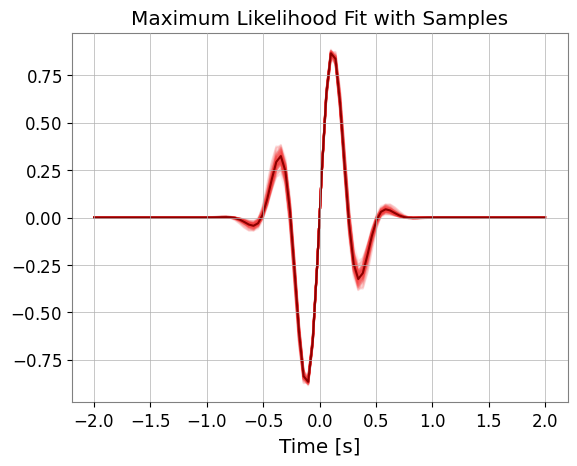

In [21]:
idx_max =numpy.argmax(result_Ms.posterior.log_likelihood)
MaxL = result_Ms.posterior.iloc[idx_max]

plt.plot(time, model_Ms(time,
                        MaxL.freq,
                        MaxL.alpha
                       ),color="#8c0000", label='Mean Estimate')

samples = result_Ms.posterior.sample(n=100)
for i in range(100):
    plt.plot(time, model_Ms(time,
                            samples.iloc[i].freq,
                            samples.iloc[i].alpha),
             color="#f54040", alpha=0.1, zorder=-100)

plt.xlabel("Time [s]")
plt.title("Maximum Likelihood Fit with Samples")


model Mt isn't fully explaining the data! There is a better model where the frequency of the sinusoid is time-dependent:

$$ M_t: s(t) = e^{-(t/\alpha)^2} \sin\left(2\pi (f_0 + \dot{f} \times t) t\right)  $$

This new model has three parameters: $f$, $\dot{f}$ and $\alpha$.


12:30 bilby INFO    : Running for label 'model_Mt', output will be saved to 'toy_model'
12:30 bilby INFO    : Analysis priors:
12:30 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:30 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
12:30 bilby INFO    : df=Uniform(minimum=-5, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:30 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:30 bilby INFO    : Analysis likelihood noise evidence: nan
12:30 bilby INFO    : Single likelihood evaluation took 4.302e-04 s
12:30 bilby INFO    : Using sampler Bilby_MCMC with kwargs {'nsamples': 1000, 'nensemble': 1, 'pt_ensemble': False, 'ntemps': 1, 'Tmax': None, 'Tmax_from_SNR': 20, 'initial_betas': None, 'adapt': True, 'adapt_t0': 100, 'adapt_nu': 10, 'pt_rejection_sample': False, 'burn_in_nact': 10, 'thin_by_nact': 1, 

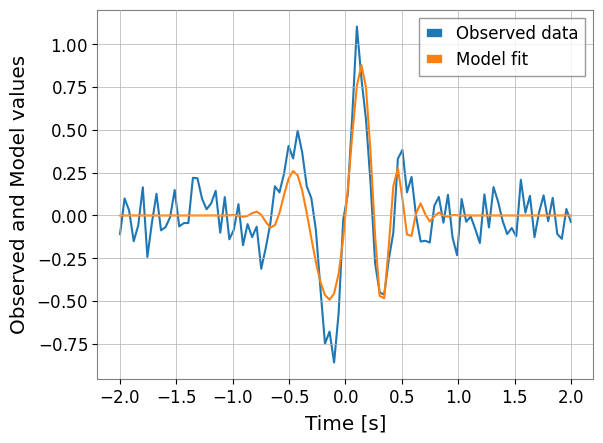

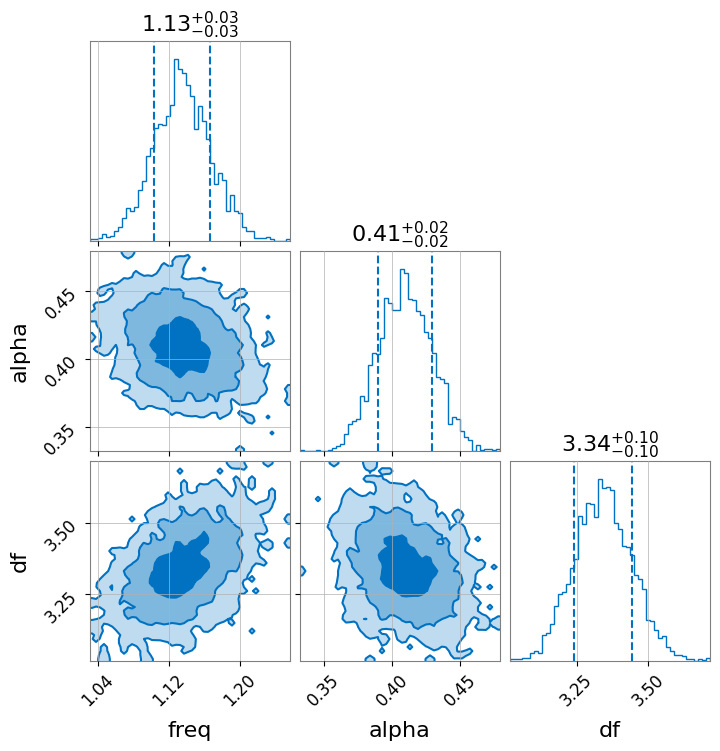

In [22]:
def model_Mt(time,alpha, freq, df):
  return numpy.exp(-(time/alpha)**2) * numpy.sin(2*(numpy.pi)*(freq+df*time)*time)

likelihood_Mt = bilby.core.likelihood.GaussianLikelihood(time, yobs, model_Mt, sigma=0.1)

##Set Alpha and Freq Bounds
priors_Mt = dict(
    freq=bilby.core.prior.Uniform(0, 5),
    alpha=bilby.core.prior.Uniform(0.01, 1),
    df=bilby.core.prior.Uniform(-5, 5)
)

result_Mt = bilby.run_sampler(
    likelihood_Mt,
    priors_Mt,
    label="model_Mt",
    outdir="toy_model",
    clean=True,
    sampler="bilby_mcmc",
    nsamples=1000,
    verbose = False,
    printdt=5,
    L1steps=1,
)




plt.plot(time, yobs)
plt.plot(time, model_Mt(time,
                        result_Mt.posterior.alpha.mean(),
                        result_Mt.posterior.freq.mean(),
                        result_Mt.posterior.df.mean()))
plt.xlabel("Time [s]")
plt.ylabel("Observed and Model values")
plt.legend(["Observed data", "Model fit"])
plt.show()

result_Mt.plot_corner()

We can tell already that the $M_t$ model is far better than $M_s$


###Calculate the Bayes factor

In [23]:
result_Mt = bilby.run_sampler(
    likelihood_Mt,
    priors_Mt,
    label="model_Mt",
    outdir="toy_model",
    clean=True,
    sampler="dynesty",
    sample="rwalk",
    nsamples=1000,
    verbose = False,
    printdt=5,
    nlive=500,
    L1steps=1,
)

result_Ms = bilby.run_sampler(
    likelihood_Ms,
    priors_Ms,
    label="model_Ms",
    outdir="toy_model",
    clean=True,
    sampler="dynesty",
    sample="rwalk",
    nsamples=1000,
    verbose = False,
    printdt=5,
    nlive=500,
    L1steps=1,
)
print(f"Bayes Factor (Mt vs Ms): {numpy.exp(result_Mt.log_evidence - result_Ms.log_evidence):.3e} → Decisive evidence for Mt")

12:31 bilby INFO    : Running for label 'model_Mt', output will be saved to 'toy_model'
12:31 bilby WARNING : Parameter logp has no default prior and is set to -3.901972669574645, this will not be sampled and may cause an error.
12:31 bilby WARNING : Parameter logl has no default prior and is set to 22.31289170882649, this will not be sampled and may cause an error.
12:31 bilby INFO    : Analysis priors:
12:31 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:31 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
12:31 bilby INFO    : df=Uniform(minimum=-5, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:31 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:31 bilby INFO    : Analysis likelihood noise evidence: nan
12:31 bilby INFO    : Single likelihood evaluation took 1.006e-04 s
12:31 bilby WARNING : S

Bayes Factor (Mt vs Ms): 6.351e+19 → Decisive evidence for Mt


Throughout all our analyses, we assumed that $\sigma=0.1$. But, what would we do if we didn't know this before? One option is to estimate it, you can do this by simply taking the standard deviation of data away from where the transient signal is. First, try to cut out the first 1s of data and use this to estimate $\sigma$, is it close to the true value $0.1$? How about taking the last second of data?

###Aproximating Standard Deviation

####Estimation

In [24]:
cropped_time= time[:25]
cropped_yobs = yobs[:25]
print("Estimated Standard Deviation (<-1s):", numpy.std(cropped_yobs))

cropped_time= time[75:]
cropped_yobs = yobs[75:]
print("Estimated Standard Deviation (>1s):", numpy.std(cropped_yobs))

Estimated Standard Deviation (<-1s): 0.12083232379507279
Estimated Standard Deviation (>1s): 0.10246210029527959


If we did not know $\sigma$ a priori, and we didn't trust our estimate, we could simply infer it from the data! You can do this by removing the `sigma=0.1` in the `GaussianLikelihood` and setting a prior on sigma. Try this using your $M_t$ model.

####Via Data

In [25]:
likelihood_Mt = bilby.core.likelihood.GaussianLikelihood(time, yobs, model_Mt)
priors_Mt = dict(
    freq=bilby.core.prior.Uniform(0, 5),
    sigma = bilby.core.prior.Uniform(0.01,0.5),
    alpha=bilby.core.prior.Uniform(0.01, 1),
    df=bilby.core.prior.Uniform(-5, 5)
)

result_Mt = bilby.run_sampler(
    likelihood_Mt,
    priors_Mt,
    label="model_Mt",
    outdir="toy_model",
    clean=True,
    sampler="dynesty",
    sample="rwalk",
    nsamples=1000,
    verbose = False,
    printdt=5,
    nlive=500,
    L1steps=1,
)

print("Standard Deviation:", result_Mt.posterior.sigma.mean())

12:31 bilby INFO    : Running for label 'model_Mt', output will be saved to 'toy_model'
12:32 bilby INFO    : Analysis priors:
12:32 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:32 bilby INFO    : sigma=Uniform(minimum=0.01, maximum=0.5, name=None, latex_label=None, unit=None, boundary=None)
12:32 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
12:32 bilby INFO    : df=Uniform(minimum=-5, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
12:32 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:32 bilby INFO    : Analysis likelihood noise evidence: nan
12:32 bilby INFO    : Single likelihood evaluation took 1.050e-04 s
12:32 bilby WARNING : Supplied argument 'nsamples' not an argument of 'Dynesty', removing.
12:32 bilby WARNING : Supplied argument 'printdt' not an argument of 'Dynesty', removing.
12:32

Standard Deviation: 0.11480591884275299


## Parameter estimation for Compact Object Mergers 3.2

In [78]:
time_of_event = 1126259462.4
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

#Fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

#Create a PSD
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

psd_alpha = 2 * H1.strain_data.roll_off / duration

H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

#Overwrite default PSDs
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

#Create Prior Values
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*numpy.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')

interferometers = [H1,L1]
waveform_arguments = dict(
    waveform_approximant='IMRPhenomXP', reference_frequency=100., catch_waveform_errors=True)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=250, dlogz=1.,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True,
)


14:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:01 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
14:01 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
14:01 bilby INFO    : Using lal version 7.6.1
14:01 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.25;Id: fafc22fe7c166517798534eeca175f27a66e0138;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:01 bilby INFO    : Using lalsimulation version 6.1.0
14:01 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.25;Id: fafc22fe7c166517798534eeca175f27a66e0138;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:01 bilby INFO    : Analysis priors:
14:

1it [00:00, ?it/s]

14:02 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
14:07 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
14:07 bilby INFO    : Rejection sampling nested samples to obtain 279 posterior samples
14:07 bilby INFO    : Sampling time: 0:05:34.932297
14:07 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/279 [00:00<?, ?it/s]

14:07 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/279 [00:00<?, ?it/s]

14:07 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/279 [00:00<?, ?it/s]

14:07 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/279 [00:00<?, ?it/s]

14:08 bilby INFO    : Summary of results:
nsamples: 279
ln_noise_evidence: -8534.562
ln_evidence: -8249.897 +/-  0.203
ln_bayes_factor: 284.664 +/-  0.203



In [79]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,31.721448,0.901236,0.000216,1.376894,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.062125,270.937424,36.147766,32.577674,29.866024,68.725440
1,30.432976,0.849231,-0.000010,1.716806,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.064683,281.920909,35.653875,30.278379,28.584067,65.932254
2,30.380025,0.770016,-0.000034,1.608505,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.064740,282.162623,37.414537,28.809788,28.532823,66.224324
3,31.738831,0.808977,-0.000157,4.428975,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.066124,288.099126,38.063462,30.792462,29.770310,68.855924
4,31.587540,0.779739,-0.000225,1.250945,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.063080,275.038242,38.712552,30.185672,29.713238,68.898224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,31.055956,0.912517,-0.000098,1.517584,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.070314,306.046432,34.898779,31.845729,29.015747,66.744508
275,31.085967,0.982749,-0.000025,1.329560,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.067185,292.649834,33.753016,33.170735,29.128931,66.923751
276,31.144444,0.946857,-0.000096,1.558732,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.063278,275.891110,34.580378,32.742682,29.290961,67.323060
277,31.021944,0.919813,-0.000031,1.502757,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.057062,249.158141,35.156101,32.337049,29.347338,67.493149


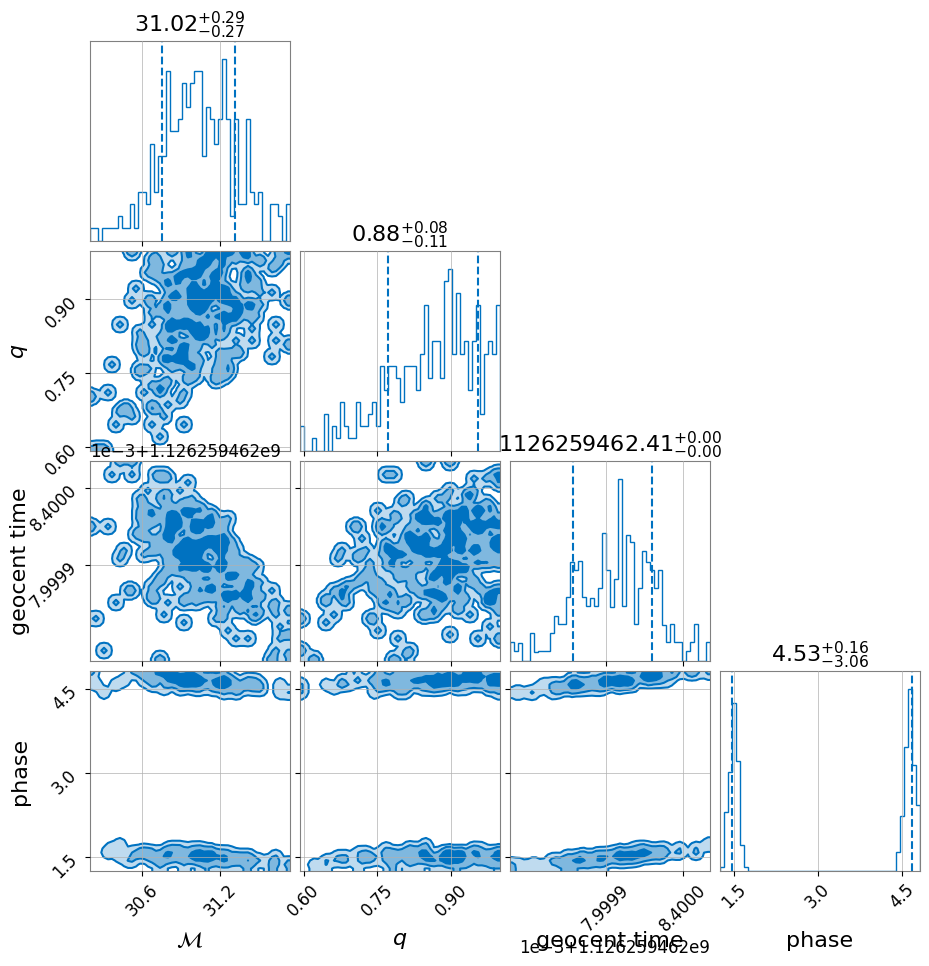

In [80]:
result_short.plot_corner(
    parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"],
    prior=True,
)

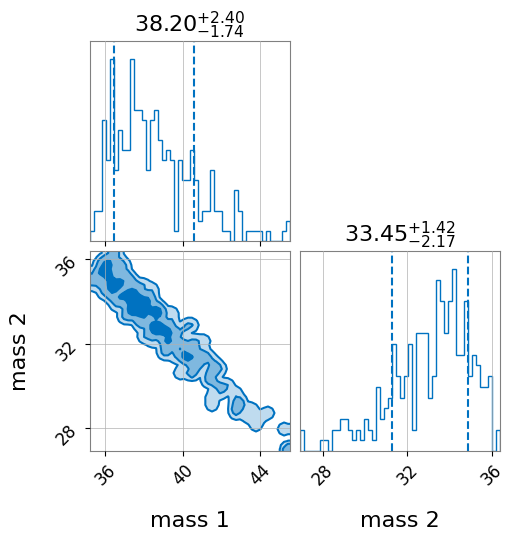

In [84]:
result_short.plot_corner(parameters=["mass_1","mass_2"])

## Challenge questions
First, let's take a closer look at the result obtained with the run above. What are the means of the chirp mass and mass ratio distributions? What are the medians of the distributions for the components masses? You can use `np.mean` and `np.median` to calculate these.

### Optional questions
Now let's expand on this example a bit. Rerun the analysis above but change the prior on the distance from a delta function to `bilby.core.prior.PowerLaw(alpha=2., minimum=50., maximum=800., name='luminosity_distance')`. You should also replace `sample='unif'` with `sample="rwalk", nact=1, walks=1` in your call to `bilby.run_sampler` above. This will take a bit longer than the original run, around ~20 minutes (something more if you are running on Colab or MyBinder). You also need to change the `label` in the call to `run_sampler` to avoid over-writing your results.

What is the median reported value of the distance posterior? What is the new log Bayes factor for signal vs. Gaussian noise? Don't be alarmed if your results do not match the official LVC results, as these are not rigorous settings.

In [83]:
print(result_short.posterior.chirp_mass.mean())
print(result_short.posterior.mass_ratio.mean())
print(result_short.posterior.mass_1.median())
print(result_short.posterior.mass_2.median())

31.030625287447396
0.8627726231917281
38.19558013883326
33.4535225056601
